In [37]:
import math
import pickle

import pandas as pd
import numpy as np
import os.path as op
import pylab as pl

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdMolDescriptors

# 1. Load data

In [2]:
major_class_df = pd.read_pickle('major_class_df.pickle')
minor_class_df = pd.read_pickle('minor_class_df.pickle')
novel_df = pd.read_pickle('novel_df.pickle')

major_class_df = major_class_df.drop(columns=['used_for_generation', 'molecular_fingerprint'])
minor_class_df = minor_class_df.drop(columns=['used_for_generation', 'molecular_fingerprint'])
novel_df = novel_df.drop(columns=['synthetic_accessibility_score', 'molecular_fingerprint'])

major_class_df.columns = ['SMILES_major']
minor_class_df.columns = ['SMILES_minor']
novel_df.columns = ['SMILES_generated']

print(major_class_df.columns)
print(minor_class_df.columns)
print(novel_df.columns)

Index(['SMILES_major'], dtype='object')
Index(['SMILES_minor'], dtype='object')
Index(['SMILES_generated'], dtype='object')


# 2. Clean data

In [3]:
def sanitize(row):
    m = Chem.MolFromSmiles(row)
    if m:
        try:
            Chem.SanitizeMol(m)
            return m
        except Exception as e:
            print(e)
            return None

In [4]:
novel_df['mol'] = novel_df.SMILES_generated.apply(sanitize)
minor_class_df['mol'] = minor_class_df.SMILES_minor.apply(sanitize)
major_class_df['mol'] = major_class_df.SMILES_major.apply(sanitize)

Sanitization error: Explicit valence for atom # 23 N, 4, is greater than permitted
Sanitization error: Explicit valence for atom # 15 N, 4, is greater than permitted
Sanitization error: Explicit valence for atom # 17 N, 4, is greater than permitted
Sanitization error: Explicit valence for atom # 6 C, 7, is greater than permitted
Sanitization error: Explicit valence for atom # 2 C, 5, is greater than permitted
Sanitization error: Explicit valence for atom # 9 C, 6, is greater than permitted
Sanitization error: Explicit valence for atom # 22 C, 6, is greater than permitted
Sanitization error: Explicit valence for atom # 22 C, 6, is greater than permitted
Sanitization error: Explicit valence for atom # 22 C, 6, is greater than permitted
Sanitization error: Explicit valence for atom # 5 O, 3, is greater than permitted
Sanitization error: Explicit valence for atom # 9 C, 5, is greater than permitted
Sanitization error: Explicit valence for atom # 20 C, 5, is greater than permitted


In [5]:
print(major_class_df.columns)
print(minor_class_df.columns)
print(novel_df.columns)

print(len(major_class_df))
print(len(minor_class_df))
print(len(novel_df))

major_class_df = major_class_df.dropna()
minor_class_df = minor_class_df.dropna()
novel_df = novel_df.dropna()

print(len(major_class_df))
print(len(minor_class_df))
print(len(novel_df))

Index(['SMILES_major', 'mol'], dtype='object')
Index(['SMILES_minor', 'mol'], dtype='object')
Index(['SMILES_generated', 'mol'], dtype='object')
285413
189940
5848
285408
189936
5836


# 3. Substructure Search

## 3.1 Rings

In [31]:
def get_ring_info(mol):
    mol = Chem.AddHs(mol)
    rc = mol.GetRingInfo().NumRings()
    nfrags = len(Chem.GetMolFrags(mol))
    ec = mol.GetNumBonds() - mol.GetNumAtoms() + nfrags
    return max(rc, ec)

In [32]:
novel_df['rings'] = novel_df.mol.apply(get_ring_info)

In [36]:
print(len(novel_df[novel_df.rings == 0]) / 5836 * 100)
print(len(novel_df[novel_df.rings == 1]) / 5836 * 100)
print(len(novel_df[novel_df.rings == 2]) / 5836 * 100)
print(len(novel_df[novel_df.rings == 3]) / 5836 * 100)
print(len(novel_df[novel_df.rings == 4]) / 5836 * 100)
print(len(novel_df[novel_df.rings > 4]) / 5836 * 100)

2.6559287183002054
7.882111034955449
19.92803289924606
31.59698423577793
29.489376285126802
8.447566826593556


In [37]:
minor_class_df['rings'] = minor_class_df.mol.apply(get_ring_info)
major_class_df['rings'] = major_class_df.mol.apply(get_ring_info)

In [42]:
print(len(minor_class_df[minor_class_df.rings == 0]) / 189936 * 100)
print(len(minor_class_df[minor_class_df.rings == 1]) / 189936 * 100)
print(len(minor_class_df[minor_class_df.rings == 2]) / 189936 * 100)
print(len(minor_class_df[minor_class_df.rings == 3]) / 189936 * 100)
print(len(minor_class_df[minor_class_df.rings == 4]) / 189936 * 100)
print(len(minor_class_df[minor_class_df.rings > 4]) / 189936 * 100)

1.658453373768006
7.743661022660264
22.350686547047427
32.32720495324741
28.082090809535842
7.83790329374105


In [41]:
print(len(major_class_df[major_class_df.rings == 0]) / 285408 * 100)
print(len(major_class_df[major_class_df.rings == 1]) / 285408 * 100)
print(len(major_class_df[major_class_df.rings == 2]) / 285408 * 100)
print(len(major_class_df[major_class_df.rings == 3]) / 285408 * 100)
print(len(major_class_df[major_class_df.rings == 4]) / 285408 * 100)
print(len(major_class_df[major_class_df.rings > 4]) / 285408 * 100)

1.6232901670590871
7.7086136338154505
22.37288373136002
32.517308554770715
27.932994169749968
7.8449097432447585


## 3.2 N, O, S

In [43]:
def contains_nitrogen(smiles):
    smiles = smiles.lower()
    if 'n' in smiles:
        return 1
    else:
        return 0

In [45]:
novel_df['contains_nitrogen'] = novel_df['SMILES_generated'].apply(contains_nitrogen)
minor_class_df['contains_nitrogen'] = minor_class_df['SMILES_minor'].apply(contains_nitrogen)
major_class_df['contains_nitrogen'] = major_class_df['SMILES_major'].apply(contains_nitrogen)

In [46]:
def contains_sulfur(smiles):
    smiles = smiles.lower()
    if 's' in smiles:
        return 1
    else:
        return 0

In [47]:
novel_df['contains_sulfur'] = novel_df['SMILES_generated'].apply(contains_sulfur)
minor_class_df['contains_sulfur'] = minor_class_df['SMILES_minor'].apply(contains_sulfur)
major_class_df['contains_sulfur'] = major_class_df['SMILES_major'].apply(contains_sulfur)

In [48]:
def contains_oxygen(smiles):
    smiles = smiles.lower()
    if 'o' in smiles:
        return 1
    else:
        return 0

In [49]:
novel_df['contains_oxygen'] = novel_df['SMILES_generated'].apply(contains_oxygen)
minor_class_df['contains_oxygen'] = minor_class_df['SMILES_minor'].apply(contains_oxygen)
major_class_df['contains_oxygen'] = major_class_df['SMILES_major'].apply(contains_oxygen)

In [50]:
halogens = ['f', 'cl', 'br', 'i', 'at']

def contains_halogen(smiles):
    smiles = smiles.lower()
    if any(hal in smiles for hal in halogens):
        return 1
    else:
        return 0

In [51]:
novel_df['contains_halogen'] = novel_df['SMILES_generated'].apply(contains_halogen)
minor_class_df['contains_halogen'] = minor_class_df['SMILES_minor'].apply(contains_halogen)
major_class_df['contains_halogen'] = major_class_df['SMILES_major'].apply(contains_halogen)

In [52]:
print(len(novel_df[novel_df.contains_nitrogen == 1]) / len(novel_df) * 100)
print(len(minor_class_df[minor_class_df.contains_nitrogen == 1]) / len(minor_class_df) * 100)
print(len(major_class_df[major_class_df.contains_nitrogen == 1]) / len(major_class_df) * 100)

92.37491432488005
94.05536601802712
93.99876667787869


In [53]:
print(len(novel_df[novel_df.contains_oxygen == 1]) / len(novel_df) * 100)
print(len(minor_class_df[minor_class_df.contains_oxygen == 1]) / len(minor_class_df) * 100)
print(len(major_class_df[major_class_df.contains_oxygen == 1]) / len(major_class_df) * 100)

92.30637422892391
93.25141100160053
93.29626359457338


In [54]:
print(len(novel_df[novel_df.contains_sulfur == 1]) / len(novel_df) * 100)
print(len(minor_class_df[minor_class_df.contains_sulfur == 1]) / len(minor_class_df) * 100)
print(len(major_class_df[major_class_df.contains_sulfur == 1]) / len(major_class_df) * 100)

37.55997258396162
39.25480161738691
39.49468830586388


In [55]:
print(len(novel_df[novel_df.contains_halogen == 1]) / len(novel_df) * 100)
print(len(minor_class_df[minor_class_df.contains_halogen == 1]) / len(minor_class_df) * 100)
print(len(major_class_df[major_class_df.contains_halogen == 1]) / len(major_class_df) * 100)

37.32008224811515
38.573519501305704
38.44916750756811


In [56]:
print(len(novel_df[(novel_df.contains_nitrogen == 0) & (novel_df.contains_oxygen == 0) & (novel_df.contains_sulfur == 0)]) / len(novel_df) * 100)
print(len(minor_class_df[(minor_class_df.contains_nitrogen == 0) & (minor_class_df.contains_oxygen == 0) & (minor_class_df.contains_sulfur == 0)]) / len(minor_class_df) * 100)
print(len(major_class_df[(major_class_df.contains_nitrogen == 0) & (major_class_df.contains_oxygen == 0) & (major_class_df.contains_sulfur == 0)]) / len(major_class_df) * 100)

0.9766963673749143
0.48437368376716367
0.4807153268303621


## 3.3 Spiro rings

In [74]:
from rdkit.Chem.rdMolDescriptors import CalcNumSpiroAtoms

def get_number_of_spiro_atoms(smiles):
    return CalcNumSpiroAtoms(Chem.MolFromSmiles(smiles))

In [75]:
novel_df['spiro_atoms'] = novel_df['SMILES_generated'].apply(get_number_of_spiro_atoms)
minor_class_df['spiro_atoms'] = minor_class_df['SMILES_minor'].apply(get_number_of_spiro_atoms)
major_class_df['spiro_atoms'] = major_class_df['SMILES_major'].apply(get_number_of_spiro_atoms)

In [76]:
print(len(novel_df[novel_df.spiro_atoms > 0]) / len(novel_df) * 100)
print(len(minor_class_df[minor_class_df.spiro_atoms > 0]) / len(minor_class_df) * 100)
print(len(major_class_df[major_class_df.spiro_atoms > 0]) / len(major_class_df) * 100)

1.9876627827278959
2.0054123494229636
1.99608980827447


## 3.4 Heterocycles

In [78]:
from rdkit.Chem.rdMolDescriptors import CalcNumHeterocycles

def get_number_of_heterocycles(smiles):
    return CalcNumHeterocycles(Chem.MolFromSmiles(smiles))

In [79]:
novel_df['heterocycles'] = novel_df['SMILES_generated'].apply(get_number_of_heterocycles)
minor_class_df['heterocycles'] = minor_class_df['SMILES_minor'].apply(get_number_of_heterocycles)
major_class_df['heterocycles'] = major_class_df['SMILES_major'].apply(get_number_of_heterocycles)

In [80]:
print(len(novel_df[novel_df.heterocycles > 0]) / len(novel_df) * 100)
print(len(minor_class_df[minor_class_df.heterocycles > 0]) / len(minor_class_df) * 100)
print(len(major_class_df[major_class_df.heterocycles > 0]) / len(major_class_df) * 100)

77.89581905414667
80.39971358773481
80.4493917479538


## 3.5 Fused rings

In [71]:
m1 = Chem.MolFromSmiles('c1c(CCO)ncnc1C(=O)O')
rs = Chem.GetMolFrags(m1,asMols=True)
for r in rs:
    AllChem.Compute2DCoords(r)
AllChem.Compute2DCoords(m1)

0

In [ ]:
AllChem.GenerateDepictionMatching2DStructure(m1,rs)

## 3.6 Functional groups
Implementation of
<br>
Peter Ertl. An algorithm to identify functional groups in organic molecules. - J Cheminform. 2017; 9: 36.
<br>
https://jcheminf.springeropen.com/articles/10.1186/s13321-017-0225-z

In [85]:
IFG Algorithm.

Implementation of

    An algorithm to identify functional groups in organic molecules
    Peter Ertl

    https://jcheminf.springeropen.com/articles/10.1186/s13321-017-0225-z


Authors:
    Richard Hall,
    Guillaume Godin modified function output to be more readable


    Usage:
    ```python
        # return the list of IFG (atomIds, atoms & type) for a molecule object:
        m = Chem.MolFromSmiles(smiles)
        fgs = identify_functional_groups(m)
        print fgs
    ```
    Output example:
        [IFG(atomIds=(2,), atoms='n', type='cnc'),
         IFG(atomIds=(4, 5, 6, 7), atoms='NS(=O)=O', type='cNS(c)(=O)=O'),
         IFG(atomIds=(12,), atoms='N', type='cN'),
         IFG(atomIds=(15,), atoms='n', type='cnc')]

Notes:

This implementation of Ertl paper was made by Richard Hall in summer 2017.
Cause RDKit and Peter tool can have distinct aromaticity dectection behaviours, list
of functionnal groups in aromatic rings may differ in presence of conjugated aromatics rings.

SyntaxError: invalid syntax (<ipython-input-85-0614ed7f7b41>, line 1)

In [6]:
from rdkit import Chem
from collections import namedtuple

def merge(mol, marked, aset):
    bset = set()
    for idx in aset:
        atom = mol.GetAtomWithIdx(idx)
        for nbr in atom.GetNeighbors():
            jdx = nbr.GetIdx()
            if jdx in marked:
                marked.remove(jdx)
                bset.add(jdx)
    if not bset:
        return
    merge(mol, marked, bset)
    aset.update(bset)

# atoms connected by non-aromatic double or triple bond to any heteroatom
# c=O should not match (see fig1, box 15).  I think using A instead of * should sort that out?
PATT_DOUBLE_TRIPLE = Chem.MolFromSmarts('A=,#[!#6]')
# atoms in non aromatic carbon-carbon double or triple bonds
PATT_CC_DOUBLE_TRIPLE = Chem.MolFromSmarts('C=,#C')
# acetal carbons, i.e. sp3 carbons connected to tow or more oxygens, nitrogens or sulfurs; these O, N or S atoms must have only single bonds
PATT_ACETAL = Chem.MolFromSmarts('[CX4](-[O,N,S])-[O,N,S]')
# all atoms in oxirane, aziridine and thiirane rings
PATT_OXIRANE_ETC = Chem.MolFromSmarts('[O,N,S]1CC1')

PATT_TUPLE = (PATT_DOUBLE_TRIPLE, PATT_CC_DOUBLE_TRIPLE, PATT_ACETAL, PATT_OXIRANE_ETC)

def identify_functional_groups(mol):
    marked = set()
    # mark all heteroatoms in a molecule, including halogens
    for atom in mol.GetAtoms():
        if atom.GetAtomicNum() not in (6,1): # would we ever have hydrogen?
            marked.add(atom.GetIdx())

    # mark the four specific types of carbon atom
    for patt in PATT_TUPLE:
        for path in mol.GetSubstructMatches(patt):
            for atomindex in path:
                marked.add(atomindex)

    # merge all connected marked atoms to a single FG
    groups = []
    while marked:
        grp = set([marked.pop()])
        merge(mol, marked, grp)
        groups.append(grp)

    # extract also connected unmarked carbon atoms
    ifg = namedtuple('IFG', ['atomIds', 'atoms', 'type'])
    ifgs = []
    for g in groups:
        uca = set()
        for atomidx in g:
            for n in mol.GetAtomWithIdx(atomidx).GetNeighbors():
                if n.GetAtomicNum() == 6:
                    uca.add(n.GetIdx())
        ifgs.append(ifg(atomIds=tuple(list(g)), atoms=Chem.MolFragmentToSmiles(mol, g, canonical=True), type=Chem.MolFragmentToSmiles(mol, g.union(uca),canonical=True)))
    return ifgs

In [7]:
def get_func_groups_from_smiles(smiles):
    m = Chem.MolFromSmiles(smiles)
    return identify_functional_groups(m)

In [8]:
%%time

novel_df['functional_groups'] = novel_df['SMILES_generated'].apply(get_func_groups_from_smiles)
minor_class_df['functional_groups'] = minor_class_df['SMILES_minor'].apply(get_func_groups_from_smiles)
major_class_df['functional_groups'] = major_class_df['SMILES_major'].apply(get_func_groups_from_smiles)

CPU times: user 10min 40s, sys: 4.14 s, total: 10min 44s
Wall time: 10min 44s


In [9]:
from rdkit.Chem.Draw import IPythonConsole #Needed to show molecules
from rdkit.Chem.Draw.MolDrawing import MolDrawing, DrawingOptions #Only needed if modifying defaults

DrawingOptions.bondLineWidth=1.8
DrawingOptions.atomLabelFontSize=14

ibu = Chem.MolFromSmiles('CC(C)Cc1ccc(cc1)C(C)C(=O)O')

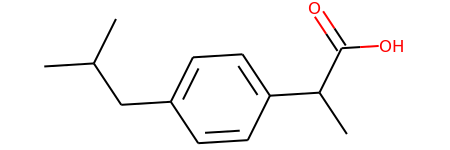

In [10]:
ibu

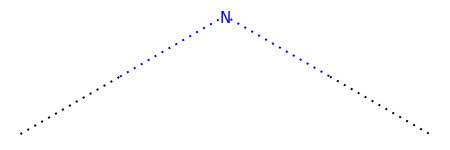

In [21]:
Chem.MolFromSmarts('cnc')

In [15]:
m = Chem.MolFromSmiles('c1nccc2n1ccc2')
AllChem.Compute2DCoords(m)
template = Chem.MolFromSmiles('c1nccc2n1ccc2')
AllChem.Compute2DCoords(template)
AllChem.GenerateDepictionMatching2DStructure(m,template)

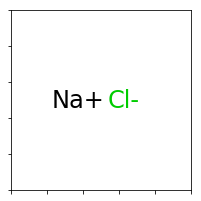

In [8]:
from rdkit.Chem import Draw

m = Chem.MolFromSmiles('[Na+].[Cl-]')
fig = Draw.MolToMPL(m, size=(100, 100))

In [81]:
func_groups = dict()

for index, row in novel_df.iterrows():
    for ifg in row['functional_groups']:
        if ifg.type in func_groups.keys():
            func_groups[ifg.type] += 1
        else:
            func_groups[ifg.type] = 1

In [82]:
func_groups = sorted(func_groups.items(), key=lambda kv: kv[1], reverse=True)

In [83]:
func_groups_total = 0

for k, v in func_groups:
    func_groups_total += v

In [84]:
print(func_groups_total)

24730


In [85]:
def count_to_frequency(count):
    return count / func_groups_total

In [86]:
func_groups_freq = dict((k, count_to_frequency(v)) for k, v in func_groups)

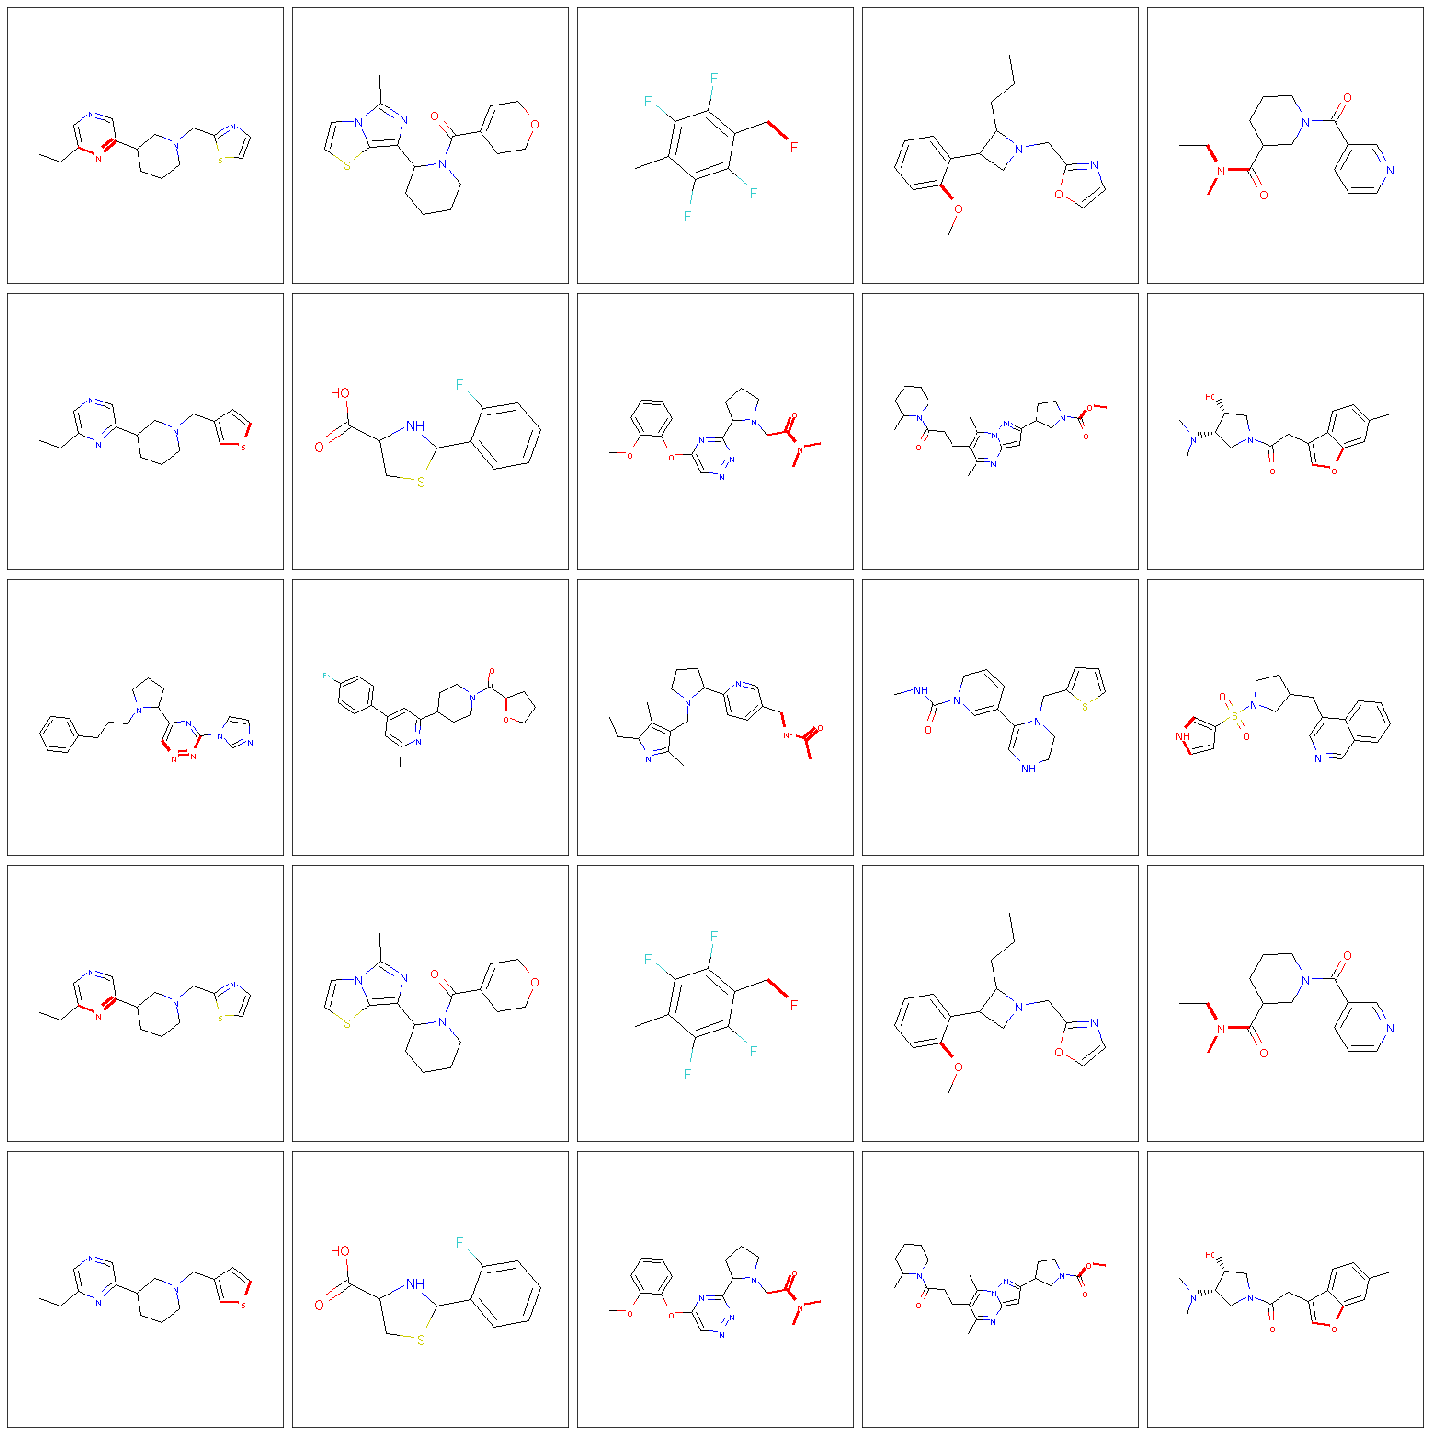

In [65]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(20,20))  # 25

i = 0
for row in axes:
    for col in row:
        col.imshow(mol_images[i % 15])
        col.axes.get_xaxis().set_visible(False)
        col.axes.get_yaxis().set_visible(False)
        i += 1

plt.tight_layout(pad=1, h_pad=None, w_pad=None, rect=None)

In [30]:
from rdkit import Chem
from rdkit.Chem.AllChem import Compute2DCoords
from rdkit.Chem.Draw import rdMolDraw2D

m = Chem.MolFromSmiles('O=C(C)Oc1ccccc1C(=O)O')
Compute2DCoords(m)
drawer = rdMolDraw2D.MolDraw2DCairo(500, 500)
drawer.DrawMolecule(m,highlightAtoms=m.GetSubstructMatch(Chem.MolFromSmarts('c1ccccc1')))
drawer.FinishDrawing()

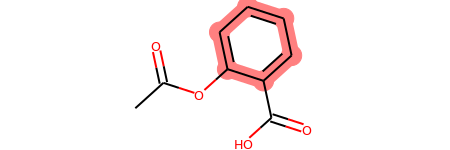

In [31]:
m

In [ ]:
from rdkit import Chem
from rdkit.Chem import rdBase
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit import RDConfig
import os
sdf = Chem.SDMolSupplier(  os.path.join(RDConfig.RDDocsDir, 'Book/data/cdk2.sdf'))
mols = [  m for m in sdf ]
core = Chem.MolFromSmiles( 'c1ncc2nc[nH]c2n1' )
img = Draw.MolsToGridImage( mols, molsPerRow=3, highlightAtomLists=[ mol.GetSubstructMatch(core) for mol in mols], useSVG=True )
img

In [108]:
func_groups_freq

{'cnc': 0.1293974929235746,
 'cOC': 0.0699150828952689,
 'cCl': 0.05418520016174687,
 'CF': 0.03906186817630408,
 'cO': 0.03348160129397493,
 'cNC(C)=O': 0.032753740396279825,
 'CN(C)C': 0.028265264860493328,
 'csc': 0.027496967246259604,
 'cF': 0.024949454104326727,
 'cn(c)C': 0.023331985442782047,
 'cSC': 0.022927618277395874,
 'c=O': 0.02284674484431864,
 'CC(=O)N(C)C': 0.022199757379700768,
 'COC': 0.021593206631621512,
 'coc': 0.021552769915082894,
 'cnnc': 0.019369187221997573,
 'CO': 0.017711281843914274,
 'cNC(c)=O': 0.016498180347755763,
 'cC(=O)N(C)C': 0.016012939749292358,
 'cN(C)C': 0.01556813586736757,
 'cBr': 0.012858875859280226,
 'CNC(C)=O': 0.012494945410432673,
 'cNC': 0.011605337646583098,
 'cC(C)=O': 0.0101900525677315,
 'c[nH]c': 0.00990699555196118,
 'cnn(c)C': 0.009826122118883947,
 'c-n(c)c': 0.009664375252729479,
 'c[N+](=O)[O-]': 0.009017387788111605,
 'cC(=O)NC': 0.008289526890416498,
 'cC(=O)OC': 0.007925596441568945,
 'CNC': 0.007157298827335221,
 'CCl': 0.

In [88]:
func_groups_undersampled = dict()

for index, row in minor_class_df.iterrows():
    for ifg in row['functional_groups']:
        if ifg.type in func_groups_undersampled.keys():
            func_groups_undersampled[ifg.type] += 1
        else:
            func_groups_undersampled[ifg.type] = 1
            
func_groups_undersampled = sorted(func_groups_undersampled.items(), key=lambda kv: kv[1], reverse=True)

func_groups_total = 0

for k, v in func_groups_undersampled:
    func_groups_total += v
    
func_groups_undersampled_freq = dict((k, count_to_frequency(v)) for k, v in func_groups_undersampled)

In [89]:
func_groups_undersampled_freq

{'cnc': 0.1321317047341867,
 'cOC': 0.09395643694284264,
 'cCl': 0.05439049954347923,
 'CF': 0.03642396486780196,
 'cNC(C)=O': 0.03297804720074973,
 'csc': 0.03188167367630084,
 'CN(C)C': 0.029147373588373857,
 'cn(c)C': 0.02771690164118312,
 'cF': 0.02683763178494193,
 'c=O': 0.02592217798399946,
 'CC(=O)N(C)C': 0.02452547771852992,
 'cSC': 0.024503767351709147,
 'coc': 0.022811564871179125,
 'COC': 0.02029798684592997,
 'cnnc': 0.018847010663408503,
 'cNC(c)=O': 0.018429689167853702,
 'cC(=O)N(C)C': 0.0163997698701117,
 'cN(C)C': 0.01629604256196802,
 'cBr': 0.015665235792675647,
 'cO': 0.014965679528450833,
 'CNC(C)=O': 0.014360201520449357,
 'c[N+](=O)[O-]': 0.012918874389848232,
 'cnn(c)C': 0.012323045433767098,
 'c[nH]c': 0.011459455286896467,
 'cC(=O)OC': 0.010213521457682274,
 'CO': 0.010115824806988808,
 'cNC': 0.009454864750445364,
 'cC(=O)NC': 0.009331839338461,
 'cC(C)=O': 0.008194457343350657,
 'c-n(c)c': 0.007458717134424561,
 'cnoc': 0.007377906324591695,
 'cN': 0.007324

In [90]:
func_groups_oversampled = dict()

for index, row in major_class_df.iterrows():
    for ifg in row['functional_groups']:
        if ifg.type in func_groups_oversampled.keys():
            func_groups_oversampled[ifg.type] += 1
        else:
            func_groups_oversampled[ifg.type] = 1
            
func_groups_oversampled = sorted(func_groups_oversampled.items(), key=lambda kv: kv[1], reverse=True)

func_groups_total = 0

for k, v in func_groups_oversampled:
    func_groups_total += v
    
func_groups_oversampled_freq = dict((k, count_to_frequency(v)) for k, v in func_groups_oversampled)

In [91]:
func_groups_oversampled_freq

{'cnc': 0.1315908789978614,
 'cOC': 0.09350993271194534,
 'cCl': 0.05454786198927083,
 'CF': 0.0371869821488041,
 'cNC(C)=O': 0.03304377134098633,
 'csc': 0.031612947232843955,
 'CN(C)C': 0.02889333820171972,
 'cn(c)C': 0.027509860488630848,
 'cF': 0.02637274452607462,
 'c=O': 0.025861563955751184,
 'cSC': 0.024791856420050797,
 'CC(=O)N(C)C': 0.024658644528883306,
 'coc': 0.022700590224975625,
 'COC': 0.020150304742263078,
 'cnnc': 0.01916245029631621,
 'cNC(c)=O': 0.018335894586060098,
 'cN(C)C': 0.016339321181091937,
 'cC(=O)N(C)C': 0.016136293419252327,
 'cBr': 0.015603445854582369,
 'cO': 0.01515325386093802,
 'CNC(C)=O': 0.014098793469407407,
 'c[N+](=O)[O-]': 0.012805193658792988,
 'cnn(c)C': 0.012302840382462574,
 'c[nH]c': 0.011610299044646045,
 'cC(=O)OC': 0.010449108643927023,
 'CO': 0.010166635236150176,
 'cNC': 0.009540699843917392,
 'cC(=O)NC': 0.009348906819887091,
 'cC(C)=O': 0.008209383413514588,
 'c-n(c)c': 0.007627584491246935,
 'cN': 0.0074839403435422325,
 'cnoc': 

In [147]:
i = 0
func_groups = []
legend = []

for k in func_groups_freq.keys():
    i += 1
    
    func_groups.append(k)
    legend.append('{} {}% {}% {}%'
        .format(k,
                round(func_groups_freq.get(k)*100, 1),
                round(func_groups_undersampled_freq.get(k)*100, 1),
                round(func_groups_oversampled_freq.get(k)*100, 1))
                )
    
    if i == 25:
        break

In [148]:
print(len(func_groups))
print(len(legend))

25
25


In [149]:
print(func_groups)

['cnc', 'cOC', 'cCl', 'CF', 'cO', 'cNC(C)=O', 'CN(C)C', 'csc', 'cF', 'cn(c)C', 'cSC', 'c=O', 'CC(=O)N(C)C', 'COC', 'coc', 'cnnc', 'CO', 'cNC(c)=O', 'cC(=O)N(C)C', 'cN(C)C', 'cBr', 'CNC(C)=O', 'cNC', 'cC(C)=O', 'c[nH]c']


In [150]:
print(legend)

['cnc 12.9% 13.2% 13.2%', 'cOC 7.0% 9.4% 9.4%', 'cCl 5.4% 5.4% 5.5%', 'CF 3.9% 3.6% 3.7%', 'cO 3.3% 1.5% 1.5%', 'cNC(C)=O 3.3% 3.3% 3.3%', 'CN(C)C 2.8% 2.9% 2.9%', 'csc 2.7% 3.2% 3.2%', 'cF 2.5% 2.7% 2.6%', 'cn(c)C 2.3% 2.8% 2.8%', 'cSC 2.3% 2.5% 2.5%', 'c=O 2.3% 2.6% 2.6%', 'CC(=O)N(C)C 2.2% 2.5% 2.5%', 'COC 2.2% 2.0% 2.0%', 'coc 2.2% 2.3% 2.3%', 'cnnc 1.9% 1.9% 1.9%', 'CO 1.8% 1.0% 1.0%', 'cNC(c)=O 1.6% 1.8% 1.8%', 'cC(=O)N(C)C 1.6% 1.6% 1.6%', 'cN(C)C 1.6% 1.6% 1.6%', 'cBr 1.3% 1.6% 1.6%', 'CNC(C)=O 1.2% 1.4% 1.4%', 'cNC 1.2% 0.9% 1.0%', 'cC(C)=O 1.0% 0.8% 0.8%', 'c[nH]c 1.0% 1.1% 1.2%']


In [106]:
mol_from_smarts = [Chem.MolFromSmarts(func_group) for func_group in func_groups]

In [157]:
from rdkit.Chem.Draw import MolToImage, ShowMol, MolsToGridImage

mols = []
smiles_unique = []
substructure_matches = []

for substr in func_groups:
    smarts = Chem.MolFromSmarts(substr)
    
    for index, row in novel_df.iterrows():
        smiles = row['SMILES_generated']
        mol = Chem.MolFromSmiles(smiles)
        match = mol.GetSubstructMatch(smarts)
        
        if match and smiles not in smiles_unique:
            mols.append(mol)
            substructure_matches.append(match)
            smiles_unique.append(smiles)
            break

In [161]:
print(len(mols))
print(len(smiles_unique))
print(len(substructure_matches))
print(len(legend))

25
25
25
25


In [159]:
print(smiles_unique)

['CCc1cc(C)nc(n1)N1CCN(CC1)C(=O)c1cnn(C)c1', 'Oc1ccc(OC)c(c1)C(=O)N1CCCC1c1cc(cc(C)n1)-c1ccc(F)cc1', 'FCNCc1cc(NC)nc(n1)C1CCCN1S(=O)(=O)c1ccccc1Cl', 'Cc1cc(nc(n1)C1CCCN1c1ccccn1)C(F)(F)F', 'COc1ccc(cc1)-c1cc(C)nc(c1)C1CCN(CC1)C(=O)c1cnn2cc(C)ccc12', 'CN(CC(=O)N1CCc2ccccc12)Cc1cc(nc(n1)C1CCCN1)CCC=C', 'CN1CCN(Cc2ccccc2)CC1C(N)=O', 'CCc1cncc(n1)C1CCCN(Cc2nccs2)C1', 'CNc1cc(CN(C)C(=O)CCCc2ccc(F)cc2)nc(n1)C1CCCC1C', 'CC(Cn1ccc(C)c1)C(=O)N1CCCCC1c1cc(cc(C)n1)-c1ccc(F)cc1', 'CC(Cc1cc(nn1C)C1CCNCC1)S(=O)(=O)c1ccc(F)c(C)c1', 'COCOC(=O)C1CCCC1c1cc(c2c(n1)n(C)c(=O)n(C)c2=O)C(F)(F)F', 'CCN(C)C(=O)C1CCCN(C1)C(=O)c1cccnc1', 'Cc1cc(cc(n1)C1CCN(CC1)C(=O)c1CCCO1)-c1ccc(F)cc1', 'Cc1nc(co1)C(=O)N1CCC(Cc2cccc3ccccc23)C1', 'CC(=C)NCCC1CCCN(C1)C(=O)c1ccn(C)n1', 'OCC(NCC1CC1)c1ccc(nc1)C1CCCN(C1)c1ncccn1', 'Cc1cc(C)N(CC(=O)N2CCCC(C2)c2ccc(cn2)C(=O)Nc2ccc(F)cc2)n1', 'Cn1ccc(n1)C(=O)N1CCCCC1c1cc(cc(C)n1)-c1ccc(F)cc1', 'CN(C)c1cc(CN(C)C(C)=O)nc(n1)C1CCCN(C1)C(=O)CC1(F)CCCCC1', 'Cc1nc(sc1CCOc1ccc(Br)cc1)C1(O)CCC

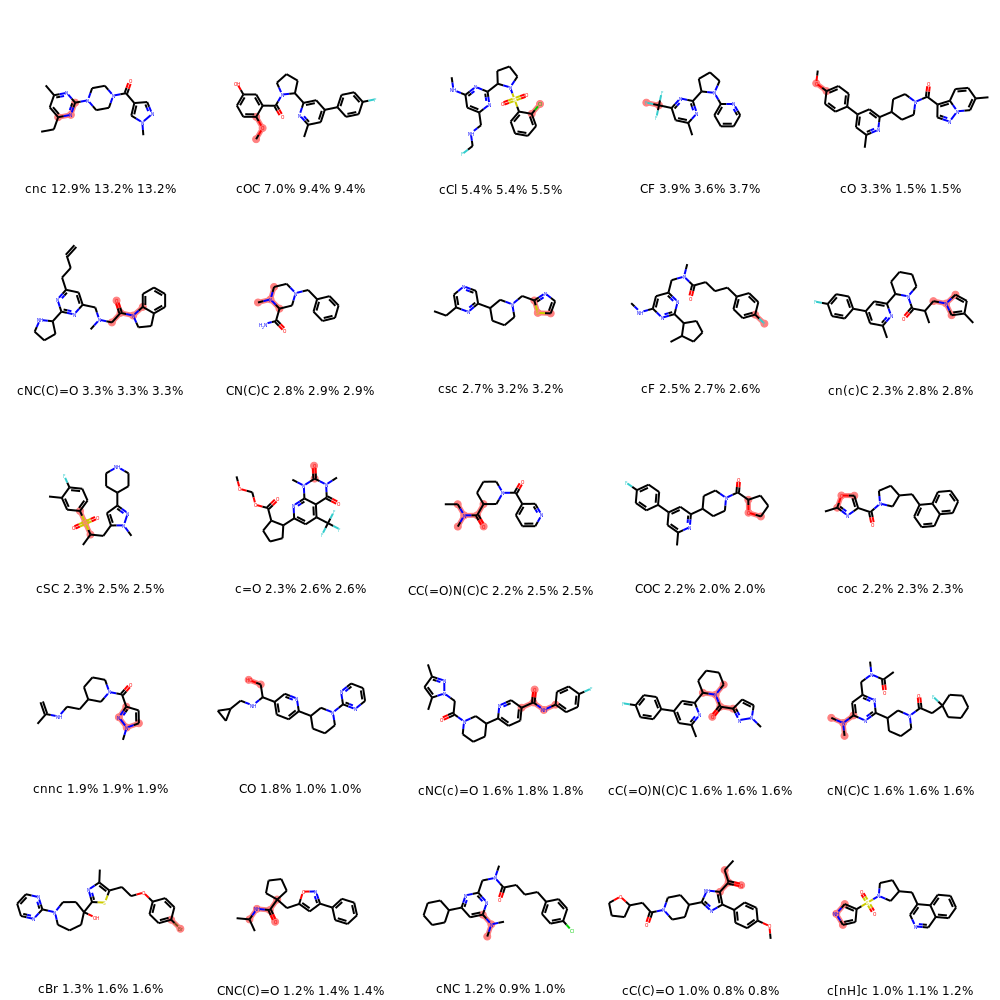

In [162]:
MolsToGridImage(mols, 
                molsPerRow=5, 
                legends=legend, 
                highlightAtomLists=substructure_matches,
#                 highlightBondColors=[(1,0,0)],
               )